# Importing Libraries

In [ ]:
%pip install category_encoders

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.7/85.7 kB 2.9 MB/s eta 0:00:00


In [ ]:
import pandas as pd
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from category_encoders.target_encoder import TargetEncoder
import re
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
def parse_mpi_range(value):
    if pd.isna(value):
        return None

    # Bỏ chữ "VND" và các ký tự không cần thiết
    value = value.replace("VND", "").replace(",", "").strip()

    # Tìm các số float (vd: 4.5, 8.9)
    numbers = re.findall(r"[\d\.]+", value)

    if len(numbers) == 1:
        return float(numbers[0])
    elif len(numbers) == 2:
        # Nếu có khoảng, lấy trung bình
        return (float(numbers[0]) + float(numbers[1])) / 2
    else:
        return None
  # Áp dụng hàm

df = pd.read_csv("/content/df_final_churn_prediction.csv")  # thay bằng file thật
df['MPI'] = df['MPI'].apply(parse_mpi_range)
y = df['is_churn']
X = df.drop(columns=['is_churn', 'RespondentID'])

In [ ]:
# Xác định biến
cat_cols = ['Gender', 'OccupationGroup', 'CompanionGroup', 'Attribute', 'DayOfWeek_mode', 'DayPart_mode']
num_cols = ['MPI', 'GroupSize', 'Age', 'Spending', 'VisitFreq_mean']


# Target Encoding categorical variables

In [ ]:
# Khởi tạo scaler và encoder
scaler = StandardScaler()
kf = KFold(n_splits=5, shuffle=True, random_state=42)

In [ ]:
# Tạo dataframe rỗng để lưu kết quả encoded
X_encoded = pd.DataFrame(index=X.index)

In [ ]:
# Cross-validation target encoding
for train_idx, valid_idx in kf.split(X):
    X_train, X_valid = X.iloc[train_idx], X.iloc[valid_idx]
    y_train = y.iloc[train_idx]

    # Fit encoder trên train
    encoder = TargetEncoder(cols=cat_cols, smoothing=0.3)
    encoder.fit(X_train[cat_cols], y_train)

    # Transform train và valid
    X_encoded.loc[train_idx, cat_cols] = encoder.transform(X_train[cat_cols])
    X_encoded.loc[valid_idx, cat_cols] = encoder.transform(X_valid[cat_cols])

# Chuẩn hóa các biến số
X_encoded[num_cols] = scaler.fit_transform(X[num_cols])

# Ghép lại để có full feature matrix
X_final = X_encoded[cat_cols + num_cols]
y_final = y

In [ ]:
X_final

,Gender,OccupationGroup,CompanionGroup,Attribute,DayOfWeek_mode,DayPart_mode,MPI,GroupSize,Age,Spending,VisitFreq_mean
0,0.354826,0.364508,0.317907,0.341616,0.370231,0.342266,-0.242332,0.534716,0.349004,0.025231,-0.646523
1,0.354826,0.372161,0.353706,0.341616,0.353274,0.367678,-0.242332,0.534716,-0.205306,-0.867812,-1.091318
2,0.385232,0.372161,0.387041,0.341616,0.370231,0.342266,-0.242332,0.534716,-1.683467,0.538068,-0.844210
3,0.385232,0.332887,0.354789,0.341616,0.353274,0.367678,-0.242332,-0.216177,1.827165,-0.544195,0.144225
4,0.385232,0.364508,0.387041,0.892583,0.370231,0.413986,-0.242332,-0.967069,2.289091,-0.551268,0.638442
...,...,...,...,...,...,...,...,...,...,...,...
11732,0.354826,0.400419,0.354789,0.341616,0.353274,0.378430,-0.242332,0.534716,-1.221542,-0.782929,-0.349993
11733,0.354826,0.332887,0.387041,0.341616,0.353274,0.367678,-0.242332,-0.216177,-1.036772,0.177314,0.144225
11734,0.385232,0.400419,0.400676,0.341616,0.370231,0.378430,1.390909,-0.967069,0.533774,0.140177,0.144225
11735,0.354826,0.332887,0.354789,0.341616,0.370231,0.367678,-0.242332,0.534716,-0.944387,0.272807,-0.185254


In [ ]:
y_final

,is_churn
0,0
1,0
2,0
3,1
4,1
...,...
11732,1
11733,0
11734,1
11735,1


In [ ]:
# Calculate the percentage of each category in y_final
category_percentages = y_final.value_counts(normalize=True) * 100

# Display the result
print("Percentage of each category in y_final:")
print(category_percentages)

Percentage of each category in y_final:
is_churn
0    62.852518
1    37.147482
Name: proportion, dtype: float64


# Training Models

## Default Models

In [ ]:
# ---------------------------
# 1️⃣ Danh sách mô hình (không SMOTE)
# ---------------------------
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000, random_state=42),
    "Random Forest": RandomForestClassifier(n_estimators=300, random_state=42),
    "XGBoost": XGBClassifier(
        n_estimators=300,
        learning_rate=0.05,
        max_depth=5,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42,
        use_label_encoder=False,
        eval_metric='logloss'
    ),
    "SVM (RBF)": SVC(kernel='rbf', C=1.0, probability=True, random_state=42)
}

# ---------------------------
# 2️⃣ Thiết lập KFold
# ---------------------------
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# ---------------------------
# 3️⃣ Hàm đánh giá từng fold
# ---------------------------
def evaluate_model(model, X_train, X_valid, y_train, y_valid):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_valid)
    y_prob = model.predict_proba(X_valid)[:, 1]

    return {
        "accuracy": accuracy_score(y_valid, y_pred),
        "precision": precision_score(y_valid, y_pred),
        "recall": recall_score(y_valid, y_pred),
        "f1": f1_score(y_valid, y_pred),
        "roc_auc": roc_auc_score(y_valid, y_prob)
    }

# ---------------------------
# 4️⃣ Chạy cross-validation
# ---------------------------
results = []

for model_name, model in models.items():
    print(f"🔹 Running 5-Fold CV for {model_name} ...")
    fold_scores = []

    for fold, (train_idx, valid_idx) in enumerate(kf.split(X_final)):
        X_train, X_valid = X_final.iloc[train_idx], X_final.iloc[valid_idx]
        y_train, y_valid = y_final.iloc[train_idx], y_final.iloc[valid_idx]

        scores = evaluate_model(model, X_train, X_valid, y_train, y_valid)
        fold_scores.append(scores)
        print(f"  Fold {fold+1}: ROC_AUC = {scores['roc_auc']:.4f}, F1 = {scores['f1']:.4f}")

    avg_scores = pd.DataFrame(fold_scores).mean().to_dict()
    avg_scores["model"] = model_name
    results.append(avg_scores)

# ---------------------------
# 5️⃣ Kết quả trung bình
# ---------------------------
results_df = pd.DataFrame(results).set_index("model").round(4)
print("\n🏁 Kết quả trung bình 5-fold (không SMOTE, có SVM):")
print(results_df)

🔹 Running 5-Fold CV for Logistic Regression ...
  Fold 1: ROC_AUC = 0.5919, F1 = 0.1920
  Fold 2: ROC_AUC = 0.6016, F1 = 0.1770
  Fold 3: ROC_AUC = 0.5861, F1 = 0.1847
  Fold 4: ROC_AUC = 0.6068, F1 = 0.2164
  Fold 5: ROC_AUC = 0.5860, F1 = 0.1778
🔹 Running 5-Fold CV for Random Forest ...
  Fold 1: ROC_AUC = 0.6779, F1 = 0.4420
  Fold 2: ROC_AUC = 0.6937, F1 = 0.4630
  Fold 3: ROC_AUC = 0.6594, F1 = 0.4207
  Fold 4: ROC_AUC = 0.6905, F1 = 0.4594
  Fold 5: ROC_AUC = 0.6912, F1 = 0.4425
🔹 Running 5-Fold CV for XGBoost ...


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [05:52:21] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


  Fold 1: ROC_AUC = 0.6937, F1 = 0.4209


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [05:52:22] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


  Fold 2: ROC_AUC = 0.7033, F1 = 0.4425


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [05:52:22] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


  Fold 3: ROC_AUC = 0.6862, F1 = 0.4210


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [05:52:23] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


  Fold 4: ROC_AUC = 0.7254, F1 = 0.4617


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [05:52:23] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


  Fold 5: ROC_AUC = 0.7152, F1 = 0.4392
🔹 Running 5-Fold CV for SVM (RBF) ...
  Fold 1: ROC_AUC = 0.5904, F1 = 0.1807
  Fold 2: ROC_AUC = 0.6144, F1 = 0.1693
  Fold 3: ROC_AUC = 0.5964, F1 = 0.1774
  Fold 4: ROC_AUC = 0.6187, F1 = 0.2074
  Fold 5: ROC_AUC = 0.6017, F1 = 0.1705

🏁 Kết quả trung bình 5-fold (không SMOTE, có SVM):
                     accuracy  precision  recall      f1  roc_auc
model                                                            
Logistic Regression    0.6634     0.8953  0.1061  0.1896   0.5945
Random Forest          0.6767     0.6146  0.3498  0.4455   0.6825
XGBoost                0.6844     0.6482  0.3301  0.4370   0.7048
SVM (RBF)              0.6616     0.8943  0.1008  0.1811   0.6043


## Models + SMOTE

In [ ]:

# ---------------------------
# 1️⃣ Danh sách mô hình
# ---------------------------
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000, random_state=42),
    "Random Forest": RandomForestClassifier(n_estimators=300, random_state=42),
    "XGBoost": XGBClassifier(
        n_estimators=300,
        learning_rate=0.05,
        max_depth=5,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42,
        use_label_encoder=False,
        eval_metric='logloss'
    ),
    "SVM": SVC(kernel='rbf', C=1.0, probability=True, random_state=42)
}

# ---------------------------
# 2️⃣ Thiết lập KFold và SMOTE
# ---------------------------
kf = KFold(n_splits=5, shuffle=True, random_state=42)
smote = SMOTE(random_state=42)

# ---------------------------
# 3️⃣ Hàm evaluate cho 1 fold
# ---------------------------
def evaluate_model(model, X_train, X_valid, y_train, y_valid):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_valid)
    y_prob = model.predict_proba(X_valid)[:, 1]

    return {
        "accuracy": accuracy_score(y_valid, y_pred),
        "precision": precision_score(y_valid, y_pred),
        "recall": recall_score(y_valid, y_pred),
        "f1": f1_score(y_valid, y_pred),
        "roc_auc": roc_auc_score(y_valid, y_prob)
    }

# ---------------------------
# 4️⃣ Cross-validation với SMOTE
# ---------------------------
results = []

for model_name, model in models.items():
    print(f"🔹 Running 5-Fold CV for {model_name} ...")
    fold_scores = []

    for fold, (train_idx, valid_idx) in enumerate(kf.split(X_final)):
        X_train, X_valid = X_final.iloc[train_idx], X_final.iloc[valid_idx]
        y_train, y_valid = y_final.iloc[train_idx], y_final.iloc[valid_idx]

        # ⚖️ Áp dụng SMOTE chỉ trên tập huấn luyện
        X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

        # Huấn luyện & đánh giá
        scores = evaluate_model(model, X_train_res, X_valid, y_train_res, y_valid)
        fold_scores.append(scores)
        print(f"  Fold {fold+1}: ROC_AUC = {scores['roc_auc']:.4f}, F1 = {scores['f1']:.4f}")

    # Trung bình 5 fold
    avg_scores = pd.DataFrame(fold_scores).mean().to_dict()
    avg_scores["model"] = model_name
    results.append(avg_scores)

# ---------------------------
# 5️⃣ Kết quả trung bình
# ---------------------------
results_df = pd.DataFrame(results).set_index("model").round(4)
print("\n🏁 Kết quả trung bình 5-fold (với SMOTE + SVM):")
print(results_df)

🔹 Running 5-Fold CV for Logistic Regression ...
  Fold 1: ROC_AUC = 0.5930, F1 = 0.4021
  Fold 2: ROC_AUC = 0.5994, F1 = 0.3887
  Fold 3: ROC_AUC = 0.5855, F1 = 0.3882
  Fold 4: ROC_AUC = 0.6065, F1 = 0.4218
  Fold 5: ROC_AUC = 0.5858, F1 = 0.3818
🔹 Running 5-Fold CV for Random Forest ...
  Fold 1: ROC_AUC = 0.6671, F1 = 0.4504
  Fold 2: ROC_AUC = 0.6771, F1 = 0.4653
  Fold 3: ROC_AUC = 0.6493, F1 = 0.4174
  Fold 4: ROC_AUC = 0.6789, F1 = 0.4721
  Fold 5: ROC_AUC = 0.6731, F1 = 0.4493
🔹 Running 5-Fold CV for XGBoost ...


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [05:45:41] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


  Fold 1: ROC_AUC = 0.6988, F1 = 0.4486


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [05:45:43] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


  Fold 2: ROC_AUC = 0.7016, F1 = 0.4492


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [05:45:44] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


  Fold 3: ROC_AUC = 0.6789, F1 = 0.4321


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [05:45:44] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


  Fold 4: ROC_AUC = 0.7219, F1 = 0.4705


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [05:45:45] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


  Fold 5: ROC_AUC = 0.7060, F1 = 0.4366
🔹 Running 5-Fold CV for SVM ...
  Fold 1: ROC_AUC = 0.6111, F1 = 0.4536
  Fold 2: ROC_AUC = 0.6143, F1 = 0.4725
  Fold 3: ROC_AUC = 0.6055, F1 = 0.4557
  Fold 4: ROC_AUC = 0.6221, F1 = 0.4912
  Fold 5: ROC_AUC = 0.6150, F1 = 0.4567

🏁 Kết quả trung bình 5-fold (với SMOTE + SVM):
                     accuracy  precision  recall      f1  roc_auc
model                                                            
Logistic Regression    0.6037     0.4564  0.3509  0.3965   0.5940
Random Forest          0.6669     0.5818  0.3685  0.4509   0.6691
XGBoost                0.6793     0.6216  0.3498  0.4474   0.7014
SVM                    0.6086     0.4727  0.4605  0.4659   0.6136


## Hyperparamenter Tuning

In [ ]:
# --- Mô hình cơ bản ---
xgb = XGBClassifier(
    random_state=42,
    use_label_encoder=False,
    eval_metric='logloss'
)

# --- Lưới tham số để fine-tune ---
param_grid = {
    'n_estimators': [100, 300, 500],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.05, 0.1],
    'subsample': [0.7, 0.8, 1.0],
    'colsample_bytree': [0.7, 0.8, 1.0],
    'gamma': [0, 0.1, 0.3]
}

# --- GridSearchCV ---
grid_search = GridSearchCV(
    estimator=xgb,
    param_grid=param_grid,
    scoring='f1',
    cv=5,
    n_jobs=-1,
    verbose=2
)

grid_search.fit(X_final, y_final)

print("✅ Best parameters:", grid_search.best_params_)
print("🏆 Best F1 score:", grid_search.best_score_)

Fitting 5 folds for each of 729 candidates, totalling 3645 fits


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [06:18:48] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


✅ Best parameters: {'colsample_bytree': 0.8, 'gamma': 0.3, 'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 500, 'subsample': 0.8}
🏆 Best F1 score: 0.4717415664939333


In [ ]:
# Train the XGBoost model with the best parameters
best_xgb_model = XGBClassifier(
    colsample_bytree=0.8,
    gamma=0.3,
    learning_rate=0.1,
    max_depth=7,
    n_estimators=500,
    subsample=0.8,
    random_state=42,
    use_label_encoder=False,
    eval_metric='logloss'
)

# Evaluate the model (using cross-validation as done before for consistency)
print("🔹 Running 5-Fold CV for the best XGBoost model with SMOTE...")
fold_scores = []

# Initialize SMOTE
smote = SMOTE(random_state=42)

for fold, (train_idx, valid_idx) in enumerate(kf.split(X_final)):
    X_train, X_valid = X_final.iloc[train_idx], X_final.iloc[valid_idx]
    y_train, y_valid = y_final.iloc[train_idx], y_final.iloc[valid_idx]

    # Apply SMOTE only on the training data
    X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

    # Train on the SMOTE-augmented training fold and evaluate on the original validation fold
    best_xgb_model.fit(X_train_res, y_train_res)
    y_pred = best_xgb_model.predict(X_valid)
    y_prob = best_xgb_model.predict_proba(X_valid)[:, 1]

    scores = {
        "accuracy": accuracy_score(y_valid, y_pred),
        "precision": precision_score(y_valid, y_pred),
        "recall": recall_score(y_valid, y_pred),
        "f1": f1_score(y_valid, y_pred),
        "roc_auc": roc_auc_score(y_valid, y_prob)
    }
    fold_scores.append(scores)
    print(f"  Fold {fold+1}: ROC_AUC = {scores['roc_auc']:.4f}, F1 = {scores['f1']:.4f}")

# Average the scores across all folds
avg_scores = pd.DataFrame(fold_scores).mean().to_dict()
print("\n🏁 Average 5-fold results for the best XGBoost model with SMOTE:")
print(pd.DataFrame([avg_scores]).round(4))

🔹 Running 5-Fold CV for the best XGBoost model with SMOTE...


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [07:54:51] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


  Fold 1: ROC_AUC = 0.6790, F1 = 0.4909


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [07:54:53] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


  Fold 2: ROC_AUC = 0.6879, F1 = 0.4852


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [07:54:54] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


  Fold 3: ROC_AUC = 0.6590, F1 = 0.4684


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [07:54:55] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


  Fold 4: ROC_AUC = 0.7060, F1 = 0.5225


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [07:54:57] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


  Fold 5: ROC_AUC = 0.7043, F1 = 0.5076

🏁 Average 5-fold results for the best XGBoost model with SMOTE:
   accuracy  precision  recall      f1  roc_auc
0    0.6612     0.5549   0.447  0.4949   0.6872


## Get feature importance

/tmp/ipython-input-1737477822.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=importance_df, x='Importance', y='Feature', palette='viridis')


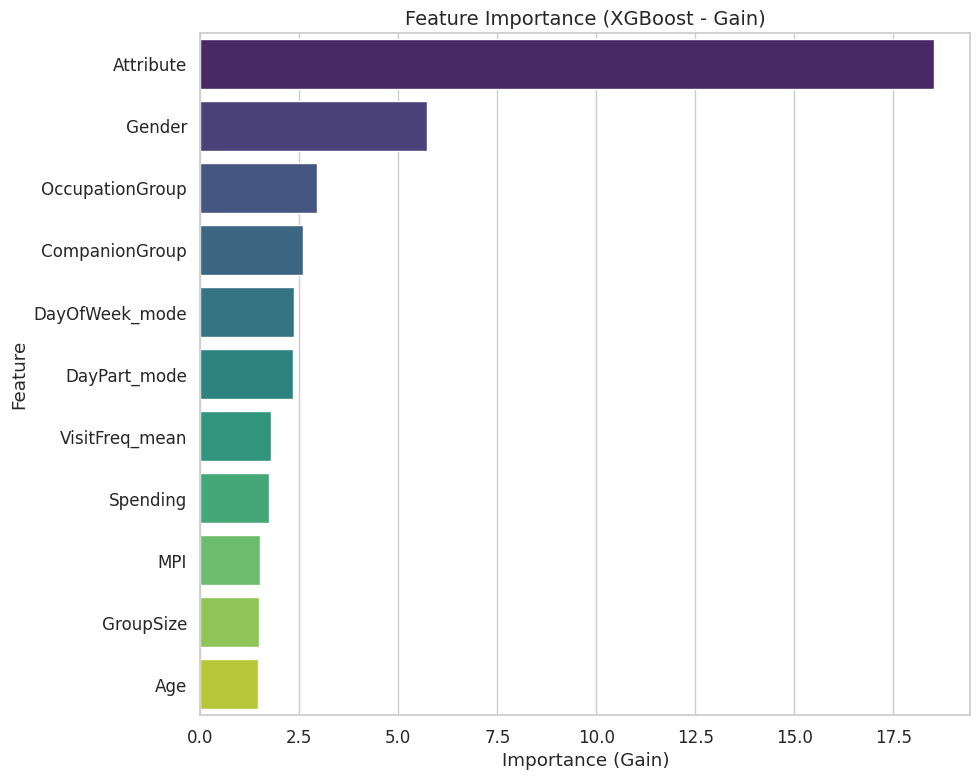


📋 Top 20 features ảnh hưởng mạnh nhất đến churn:
            Feature  Importance
3         Attribute   18.518656
0            Gender    5.733407
1   OccupationGroup    2.957462
2    CompanionGroup    2.601267
4    DayOfWeek_mode    2.351748
5      DayPart_mode    2.343934
10   VisitFreq_mean    1.786088
9          Spending    1.745259
6               MPI    1.516034
7         GroupSize    1.489848
8               Age    1.451023


In [ ]:
# Lấy importance scores từ mô hình sau cùng (đã train trong vòng lặp)
importance = best_xgb_model.get_booster().get_score(importance_type='gain')

# Chuyển sang DataFrame để dễ quan sát
importance_df = pd.DataFrame({
    'Feature': list(importance.keys()),
    'Importance': list(importance.values())
}).sort_values(by='Importance', ascending=False)

# Hiển thị top 20 feature quan trọng nhất
plt.figure(figsize=(10, 8))
sns.barplot(data=importance_df, x='Importance', y='Feature', palette='viridis')
plt.title('Feature Importance (XGBoost - Gain)', fontsize=14)
plt.xlabel('Importance (Gain)')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

# In toàn bộ danh sách feature importance (tùy chọn)
print("\n📋 Top 20 features ảnh hưởng mạnh nhất đến churn:")
print(importance_df)